<h1 align="center"><strong>Machine translation</strong></h1>

Machine translation (MT) is the study of how to use computers to translate from one language into another. In terms of methodologies MT mainly falls in two categories: rule-based methods and corpus-based-methods.  

In this short notebook a dataset containing japanese and english text will be loaded and prepared for a machine translation task.  
The preparation will limit itself to the extraction of the sentence pair and the splitting into train and test set. 

# Import 

In [1]:
import kagglehub
from pathlib import Path
import pandas as pd
import xml.etree.ElementTree as ET
from pprint import pprint
from collections import Counter
from sklearn.model_selection import train_test_split 
import tqdm as notebook_tqdm
import matplotlib.pyplot as plt

import utils

import logging
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)


c:\Users\laran\Home\Documents\code\venv\NLPvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [2]:
# Download latest version
root=Path(kagglehub.dataset_download("team-ai/japaneseenglish-bilingual-corpus"))
print(root)


C:\Users\laran\.cache\kagglehub\datasets\team-ai\japaneseenglish-bilingual-corpus\versions\3


In [3]:
files=sorted(p for p in root.rglob("*") if p.is_file())
pprint(files[:10])

[WindowsPath('C:/Users/laran/.cache/kagglehub/datasets/team-ai/japaneseenglish-bilingual-corpus/versions/3/BDS00389.xml'),
 WindowsPath('C:/Users/laran/.cache/kagglehub/datasets/team-ai/japaneseenglish-bilingual-corpus/versions/3/fonts-japanese-gothic.ttf'),
 WindowsPath('C:/Users/laran/.cache/kagglehub/datasets/team-ai/japaneseenglish-bilingual-corpus/versions/3/kyoto_lexicon.csv'),
 WindowsPath('C:/Users/laran/.cache/kagglehub/datasets/team-ai/japaneseenglish-bilingual-corpus/versions/3/readme.pdf'),
 WindowsPath('C:/Users/laran/.cache/kagglehub/datasets/team-ai/japaneseenglish-bilingual-corpus/versions/3/wiki_corpus_2.01/BDS/BDS00001.xml'),
 WindowsPath('C:/Users/laran/.cache/kagglehub/datasets/team-ai/japaneseenglish-bilingual-corpus/versions/3/wiki_corpus_2.01/BDS/BDS00002.xml'),
 WindowsPath('C:/Users/laran/.cache/kagglehub/datasets/team-ai/japaneseenglish-bilingual-corpus/versions/3/wiki_corpus_2.01/BDS/BDS00003.xml'),
 WindowsPath('C:/Users/laran/.cache/kagglehub/datasets/team-

Files are mostly XML files, to be able to use the parallel english / japanese text the XML files must be parsed first: 

### 1) check the tags

In [4]:
base = root / "wiki_corpus_2.01" / "BDS"
xml_file = sorted(base.glob("BDS*.xml"))[0]
root = ET.parse(xml_file).getroot()

for el in root.iter():
    print(el.tag, el.attrib)
    # Stop early to avoid printing everything
    if len(list(el)) > 0:
        break


art {'orl': 'ja', 'trl': 'en'}


Tags are 'ja' for japanese and 'en' for english.  
The structure will be further explored to properly extract japanese - english pairs

### 2. inspect the structure

In [5]:
assert root.tag.endswith("art") and root.attrib.get("orl")=="ja" and root.attrib.get("trl")=="en"

# List first-level children under <art>
lvl1 = [c.tag for c in root]

print("Level-1 child tags:", Counter(lvl1))

# Peek deeper: for each distinct lvl1 tag, show its distinct children and sample text
def strip_ns(tag): 
    return tag.split("}",1)[1] if "}" in tag else tag

seen = set()
for c in root:
    t = strip_ns(c.tag)
    if t in seen: 
        continue
    seen.add(t)
    sub = [strip_ns(x.tag) for x in list(c)]
    print(f"\n<{t}> children:", Counter(sub))
    # print a couple of leaf texts
    for leaf in c.iter():
        if len(list(leaf))==0 and (leaf.text or "").strip():
            txt = leaf.text.strip().replace("\n"," ")[:120]
            print(f"  sample leaf <{strip_ns(leaf.tag)}>: {txt}")
            break


Level-1 child tags: Counter({'sec': 6, 'par': 5, 'inf': 1, 'tit': 1, 'copyright': 1})

<inf> children: Counter()
  sample leaf <inf>: jawiki-20080607-pages-articles.xml

<tit> children: Counter({'e': 3, 'cmt': 3, 'j': 1})
  sample leaf <j>: 雪舟

<par> children: Counter({'sen': 2})
  sample leaf <j>: 雪舟（せっしゅう、1420年（応永27年） - 1506年（永正3年））は号で、15世紀後半室町時代に活躍した水墨画家・禅僧で、画聖とも称えられる。

<sec> children: Counter({'par': 3, 'tit': 1})
  sample leaf <j>: 生涯

<copyright> children: Counter()
  sample leaf <copyright>: copyright (c) 2010 Avanzare(id:34657), Kanejan(id:78613), Tommy6(id:51773), Nnh(id:474), Suguri F(id:11127), FREEZA(id:6


**interpretation**: 
- Root is: <art orl="ja" trl="en">
- frequent childrens are: sec, par, tit, inf, copyright
- language tags are: < j > for japanese and < e > for english 


With these informations we can built the extractor. 

### 3) Built the extractor and the paired dataframe

In [6]:
# base = root / "wiki_corpus_2.01" / "BDS"
base.glob("BDS*.xml")

TAG_PAIR      = None         # No wrapper available
TAG_ORIGINAL  = "j"          # japanese tag
TAG_TRANSL    = "e"          # english tag

def strip_ns(tag):
    return tag.split("}",1)[1] if "}" in tag else tag

def text_or_none(el):
    return (el.text or "").strip() if el is not None and el.text else None

pairs = []
for xf in sorted(base.glob("BDS*.xml")):
    root = ET.parse(xf).getroot()

    if TAG_PAIR:
        # option 1 --> if I have the wrapper (not our case as TAG_PAIR=None)
        for node in root.findall(f".//{TAG_PAIR}"):
            ja = text_or_none(node.find(TAG_ORIGINAL))
            en = text_or_none(node.find(TAG_TRANSL))
            if ja and en:
                pairs.append((ja, en))
    else:
        # option 2 --> called in case we have no explicit wrapper (our case)
        for node in root.iter():
            children = list(node)
            if not children: 
                continue
            tagmap = {strip_ns(c.tag).lower(): c for c in children}
            if TAG_ORIGINAL.lower() in tagmap and TAG_TRANSL.lower() in tagmap:
                ja = text_or_none(tagmap[TAG_ORIGINAL.lower()])
                en = text_or_none(tagmap[TAG_TRANSL.lower()])
                if ja and en:
                    pairs.append((ja, en))

df = pd.DataFrame(pairs, columns=["ja", "en"]).dropna()   # dataframe and cleaning


### 4) inspect the newly created dataframe.  

Does it make sense? were the tag correctly extracted?

In [7]:
df.head(5)

,ja,en
0,雪舟,Sesshu
1,雪舟（せっしゅう、1420年（応永27年） - 1506年（永正3年））は号で、15世紀後半...,"Known as Sesshu (1420 - 1506), he was an ink p..."
2,日本の水墨画を一変させた。,He revolutionized the Japanese ink painting.
3,諱は「等楊（とうよう）」、もしくは「拙宗（せっしゅう）」と号した。,"He was given the posthumous name ""Toyo"" or ""Se..."
4,備中国に生まれ、京都・相国寺に入ってから周防国に移る。,"Born in Bicchu Province, he moved to Suo Provi..."


In [8]:
print("Total pairs:", len(df))

Total pairs: 28384


### 5) Prepare the data for machine translation

In [9]:
X = df['ja']   # original 
y = df['en']   # translated

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.1,  # for the validation set
    random_state=42
)

In [10]:
# checks
print(f"----Overview----")
print("")
print(f"Training set size: {len(X_train)} entries")
print(f"Testing set size: {len(X_test)} entries")
print(f"Validation set size: {len(X_val)} entries")

----Overview----

Training set size: 20436 entries
Testing set size: 5677 entries
Validation set size: 2271 entries


## Tokenization & Model 

The model selected is the multilingual Bart from Huggingface (https://huggingface.co/docs/transformers/en/model_doc/bart).   
It will be set-up to be fine tuned on the dataset containing many historical and artistic information. Due to the resources required the model will not be trained, but his pre-trained version will be used instead.  

Scoring will be performed from BLEU score, which evaluate the sequence of words between the generated sentence and the original, and also by BERTScore which evaluate instead the semantical similarity between the generated text and the reference one. 

In [11]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
import torch
from transformers import Trainer, TrainingArguments
from datasets import Dataset
from transformers import DataCollatorForSeq2Seq
from sacrebleu import corpus_bleu, sentence_bleu
import numpy as np

import torch.nn.functional as F
import random
import copy

from bert_score import score

from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

In [12]:
# model and tokenizer initialization
model_name="facebook/mbart-large-50-many-to-many-mmt"
tokenizer=MBart50TokenizerFast.from_pretrained(model_name)
model=MBartForConditionalGeneration.from_pretrained(model_name)

In [13]:
tokenizer.src_lang= "ja_XX"   # source language (original) = japanese
tokenizer.tgt_lang= "en_XX"    # translated language  = english

In [14]:
def preprocess_function(examples):
    inputs= tokenizer(
        examples['ja'], 
        max_length=128, 
        truncation=True, 
        padding=True
    )

    with tokenizer.as_target_tokenizer():
        labels=tokenizer(
            examples['en'], 
            max_length=128, 
            truncation=True, 
            padding=True
        )
    inputs["labels"]=labels["input_ids"]
    return inputs

In [15]:
train_dataset = Dataset.from_pandas(pd.DataFrame({
    'ja': X_train, 
    'en': y_train
}))

val_dataset = Dataset.from_pandas(pd.DataFrame({
    'ja': X_val, 
    'en': y_val
}))

test_df=pd.DataFrame({'ja': X_test, 'en':y_test})

In [16]:
train_dataset=train_dataset.map(preprocess_function, batched=True)
val_dataset=val_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/20436 [00:00<?, ? examples/s]c:\Users\laran\Home\Documents\code\venv\NLPvenv\Lib\site-packages\transformers\tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 2271/2271 [00:00<00:00, 14391.27 examples/s]


In [17]:
data_collator=DataCollatorForSeq2Seq(
    tokenizer=tokenizer, 
    model=model, 
    padding=True
)

In [18]:
# GPU setup
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

CUDA available: True
GPU count: 1
Current GPU: NVIDIA GeForce RTX 4070 Laptop GPU
GPU memory: 8.6 GB


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Model is on: {model.device}")

Model is on: cuda:0


In [20]:
training_args = TrainingArguments(
    output_dir='./mbart-cultural-ja-en',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="steps",
    eval_steps=1000,
    save_steps=2000,
    load_best_model_at_end=True,
    fp16=True,  # Enables mixed precision - faster training on modern GPUs
)

c:\Users\laran\Home\Documents\code\venv\NLPvenv\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
if torch.cuda.is_available():
    gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
    
    if gpu_memory_gb >= 16:
        batch_size = 8  # Can handle larger batches
    elif gpu_memory_gb >= 8:
        batch_size = 4  # Your current setting
    else:
        batch_size = 2  # Smaller GPU
        
    print(f"Using batch size: {batch_size}")
    
    # Update your training args
    training_args.per_device_train_batch_size = batch_size
    training_args.per_device_eval_batch_size = batch_size

Using batch size: 4


In [22]:
trainer=Trainer(
    model=model, 
    args=training_args, 
    train_dataset=train_dataset, 
    eval_dataset=val_dataset, 
    data_collator=data_collator,
    tokenizer=tokenizer 
)

C:\Users\laran\AppData\Local\Temp\ipykernel_57772\1253686246.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(


In [23]:
# print("Starting training...")
# trainer.train()

Time required is approx 15h training. We will use a pre-trained model without MLE fine tutning. 

In [24]:
sample_idx= 5
test_ja=X_test.iloc[sample_idx]
test_en_reference=y_test.iloc[sample_idx]

inputs = tokenizer(test_ja, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"])
result = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Using sample {sample_idx} from test dataset")
print(f"Japanese: {test_ja}")
print(f"English reference: {test_en_reference}")
print(f"Model translation: {result}")

Using sample 5 from test dataset
Japanese: 管長を補佐する宗務総監の指揮監督の下、庶務部・教学部・海外部・渉外部・財務部の5部門によって宗務行政が分担される近代的事務機構が構築されている。
English reference: There is a modern official system established and general political matters are divided into five divisions under the supervision of the General Office Director who supports kancho, such as Shomubu (General Affairs Department), Kyogakubu (Educational Department), Kaigaibu (Overseas Department), Shogaibu (Public Relations Department) and Zaimubu (Finance Department).
Model translation: Under the supervision of the Director General of Sectarian Affairs, who assists the Director General, a modern administrative organization has been established in which Sectarian administration is divided into five departments: the Department of General Affairs, the Department of Teaching, the Department of Overseas Affairs, the Department of External Relations, and the Department of Finance.


In [25]:
print("model evaluation before optimization")
print("#"*20)
print(" ")

baseline_results = utils.evaluate_model(model, tokenizer, X_test, y_test, max_samples=50)

model evaluation before optimization
####################
 
Evaluating on 50 samples...

Example 1:
JA:  1917年（大正6年）勧学が追贈されている。
REF: In 1917, he was promoted to Kangaku ranking after his death.
GEN: In 1917, he was promoted to Kangaku.
BLEU: 45.69, BERTScore F1: 0.963

Example 2:
JA:  それゆえに直日・直堂も、修行者も、両者ともが警策を「与える」・「いただく」前後に合掌低頭し、お互いに感謝の意を表わす。
REF: Therefore, both of Jikijitsu or jikido and meditators make the gassho (place the palms of the hands together in the position of prayer) and bow their head to show their gratitude each other, before and after the keisaku (kyosaku) is to "give" and "receive".
GEN: Therefore, both Naoki and Naodo, as well as the practitioners, both "give" and "receive" the precaution, holding their hands and lowering their heads, expressing their gratitude to each other.
BLEU: 1.75, BERTScore F1: 0.878

Example 3:
JA:  古市 胤栄（ふるいち いんえい、生年不詳 - 永正2年（1505年））は、戦国時代 (日本)の僧・武将。
REF: Ine FURUICHI (year of birth unknown - 1505) is a priest and a Japanese military comman

In [ ]:
print("pre_optimization metrics")
print("#"*20)
print(f"Corpus BLEU: {baseline_results['corpus_bleu']:.2f}")
print(f"Corpus Bert: {baseline_results['corpus_bert']:.2f}")
print(f"Average Sentence BLEU: {baseline_results['avg_sentence_bleu']:.2f} ± {baseline_results['std_sentence_bleu']:.2f}")

baseline_corpus_bleu=baseline_results['corpus_bleu']
baseline_corpus_bert=baseline_results['corpus_bert']
baseline_avg_bleu=baseline_results['avg_sentence_bleu']   
   

pre_optimization metrics
####################
Corpus BLEU: 0.00
Corpus Bert: 0.90
Average Sentence BLEU: 11.53 ± 15.78


##  Model optimization through RL

In [27]:
def compute_bleu_reward(generated_text, reference_text):
    """Compute sentence-level BLEU as reward"""
    try:
        bleu = sentence_bleu(generated_text, [reference_text]).score / 100.0
        return max(bleu, 0.01)  # Avoid zero rewards
    except:
        return 0.01
    
def compute_bert_reward(generated_text, reference_text):
    """Compute semantic level Bert score as reward"""
    P, R, F1 = score(
        [generated_text], 
        [reference_text], 
        lang="en",
        verbose=False,
    )
    return F1.item()

def rl_training_step(model, tokenizer, batch_ja, batch_en_ref, optimizer):
    """Single RL training step using reinforcement learning"""
    model.train()
    total_loss = 0
    
    for ja_text, en_ref in zip(batch_ja, batch_en_ref):
        # Tokenize input
        inputs = tokenizer(ja_text, return_tensors="pt", max_length=128, truncation=True).to("cuda")
        
        # not greedy --> RL
        with torch.no_grad():
            generated_outputs = model.generate(
                **inputs,
                forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"],
                max_length=128,
                do_sample=True,  # must sample for RL
                temperature=1.0,
                pad_token_id=tokenizer.pad_token_id,
                return_dict_in_generate=True,
                output_scores=True
            )
        
        # reward setup
        generated_ids = generated_outputs.sequences[0]
        generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
        bleu_reward = compute_bleu_reward(generated_text, en_ref)
        bert_reward=compute_bert_reward(generated_text, en_ref)

        reward=0.5* bleu_reward + 0.5* bert_reward
        reward=float(reward)
        
        # forward pass
        decoder_input_ids = generated_ids[:-1].unsqueeze(0)  # remove last token
        labels = generated_ids[1:].unsqueeze(0)  
        
        outputs = model(
            input_ids=inputs.input_ids,
            decoder_input_ids=decoder_input_ids,
            labels=labels
        )
        
        log_probs = F.log_softmax(outputs.logits, dim=-1)
        selected_log_probs = log_probs.gather(2, labels.unsqueeze(-1)).squeeze(-1)
        
        # Policy grandient negative to maximize reward
        loss = -selected_log_probs.mean() * reward
        total_loss += loss 

        print(f"JA: {ja_text[:50]}...")
        print(f"Generated: {generated_text}")
        print(f"Reference: {en_ref}")
        print(f"BLEU Reward: {reward:.3f}")
        print(f"Loss: {loss.item():.3f}")
        print("-" * 60)
    
    # update to new state
    avg_loss = total_loss / len(batch_ja)
    avg_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return avg_loss.item()



In [28]:
# copying th eoriginal model to have a comparison after optimization

model_baseline = copy.deepcopy(model)
model_baseline.eval()
model_RL = model

Starting RL training
####################

--- RL Step 1/30 ---
JA: 現在では臨済宗・黄檗宗と曹洞宗で、役職の位置づけがやや異なる。...
Generated: At present, the positions of official positions are slightly different in the Rinzai Sect, the Huangxi Sect, and the Caodong Sect.
Reference: Today, the details of the position differ slightly between the Rinzai/Obaku sects and the Soto sect.
BLEU Reward: 0.458
Loss: 0.278
------------------------------------------------------------
JA: 阿弥陀寺（あみだじ）は、京都市上京区にある浄土宗の寺院。...
Generated: Amida-ji Temple is a temple of the Jodo sect located in Kamigyo Ward, Kyoto City.
Reference: Amida-ji Temple is the temple of the Jodo (Pure Land) sect in Kamigyo Ward, Kyoto City.
BLEU Reward: 0.490
Loss: 0.148
------------------------------------------------------------
Average Loss: 0.2132

--- RL Step 2/30 ---
JA: これに土をかぶせる。...
Generated: I'll put the soil on it.
Reference: Next, covered it up with clay soil.
BLEU Reward: 0.466
Loss: 0.437
--------------------------------------------------------

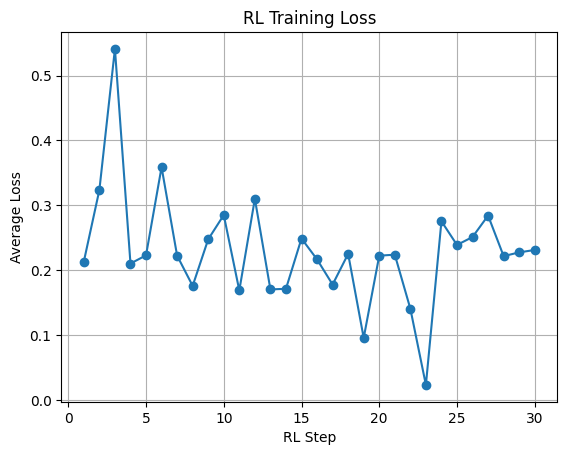

In [29]:
# application of RL optimization
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
model_RL=model

batch_size = 2
num_rl_steps = 30  # 10 steps, adapt to more if time

losses = []

print("Starting RL training")
print("#"*20)

for step in range(num_rl_steps):
    batch_indices = random.sample(range(len(X_train[:100])), batch_size) # random batch
    batch_ja = [X_train.iloc[i] for i in batch_indices]
    batch_en = [y_train.iloc[i] for i in batch_indices]
    
    print(f"\n--- RL Step {step+1}/{num_rl_steps} ---")
    loss = rl_training_step(model_RL, tokenizer, batch_ja, batch_en, optimizer)
    losses.append(loss)
    print(f"Average Loss: {loss:.4f}")

print("RL training completed")
print("#"*20)

plt.plot(range(1, len(losses)+1), losses, marker="o")
plt.xlabel("RL Step")
plt.ylabel("Average Loss")
plt.title("RL Training Loss")
plt.grid(True)
plt.show()

In [30]:
sample_idx= 5
test_ja=X_test.iloc[sample_idx]
test_en_reference=y_test.iloc[sample_idx]

inputs = tokenizer(test_ja, return_tensors="pt").to("cuda")
outputs = model_RL.generate(**inputs, forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"])
result_rl = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Using sample {sample_idx} from test dataset")
print(f"Japanese: {test_ja}")
print(f"English reference: {test_en_reference}")
print(f"Model translation: {result_rl}")

Using sample 5 from test dataset
Japanese: 管長を補佐する宗務総監の指揮監督の下、庶務部・教学部・海外部・渉外部・財務部の5部門によって宗務行政が分担される近代的事務機構が構築されている。
English reference: There is a modern official system established and general political matters are divided into five divisions under the supervision of the General Office Director who supports kancho, such as Shomubu (General Affairs Department), Kyogakubu (Educational Department), Kaigaibu (Overseas Department), Shogaibu (Public Relations Department) and Zaimubu (Finance Department).
Model translation: Under the command and supervision of the Director General of Sectarian Affairs, who assists the Chief Executive, a modern administrative machinery has been constructed, which is divided into sectarian administration by the five departments of the Department of General Affairs, the Department of Teaching, the Department of Overseas Affairs, the Department of External Relations, and the Department of Finance.


In [31]:
optimized_results = utils.evaluate_model(model_RL, tokenizer, X_test, y_test, max_samples=50)

Evaluating on 50 samples...

Example 1:
JA:  1917年（大正6年）勧学が追贈されている。
REF: In 1917, he was promoted to Kangaku ranking after his death.
GEN: In 1917, Kangaku was exiled.
BLEU: 4.07, BERTScore F1: 0.929

Example 2:
JA:  それゆえに直日・直堂も、修行者も、両者ともが警策を「与える」・「いただく」前後に合掌低頭し、お互いに感謝の意を表わす。
REF: Therefore, both of Jikijitsu or jikido and meditators make the gassho (place the palms of the hands together in the position of prayer) and bow their head to show their gratitude each other, before and after the keisaku (kyosaku) is to "give" and "receive".
GEN: Therefore, Naoki, Naido, and the practitioners both show their gratitude to each other by lowering their hands before and after "giving" and "receiving."
BLEU: 3.48, BERTScore F1: 0.891

Example 3:
JA:  古市 胤栄（ふるいち いんえい、生年不詳 - 永正2年（1505年））は、戦国時代 (日本)の僧・武将。
REF: Ine FURUICHI (year of birth unknown - 1505) is a priest and a Japanese military commander during the Sengoku period.
GEN: Taneie FURICHI (year of birth unknown - 1505) was a priest and a武将 in th

In [ ]:
print("pre_optimization metrics")
print("#"*20)
print(f"Corpus BLEU: {optimized_results['corpus_bleu']:.2f}")
print(f"Corpus Bert: {optimized_results['corpus_bert']:.2f}")
print(f"Average Sentence BLEU: {optimized_results['avg_sentence_bleu']:.2f} ± {optimized_results['std_sentence_bleu']:.2f}")

optimized_corpus_bleu=optimized_results['corpus_bleu']
optimized_corpus_bert=optimized_results['corpus_bert']
optimized_avg_bleu=optimized_results['avg_sentence_bleu'] 

pre_optimization metrics
####################
Corpus BLEU: 0.00
Corpus Bert: 0.90
Average Sentence BLEU: 9.57 ± 12.05


In [ ]:
print(f"Corpus BLEU: {baseline_results['corpus_bleu']:.2f}")
print(f"Corpus Bert: {baseline_results['corpus_bert']:.2f}")

print(f"Corpus BLEU: {optimized_results['corpus_bleu']:.2f}")
print(f"Corpus Bert: {optimized_results['corpus_bert']:.2f}")

Corpus BLEU: 0.00
Corpus Bert: 0.90
Corpus BLEU: 0.00
Corpus Bert: 0.90


# But how good are the transformers compared to old models?

## Example based Machine translation (EBMT)

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [35]:
X = df['ja']   # original 
y = df['en']   # translated

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.1,  # for the validation set
    random_state=42
)

In [36]:
def ebmt_tfidf_baseline(X_train, y_train, X_test):
    """
    Example-Based MT baseline using TF-IDF + nearest neighbor retrieval.
    For each test sentence in Japanese, returns the English translation
    of the most similar Japanese sentence from the training set.
    """
    # Fit TF-IDF on Japanese training sentences
    vectorizer = TfidfVectorizer()
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    translations = []
    for i in range(X_test_vec.shape[0]):
        # Compute cosine similarity to all training sentences
        sims = cosine_similarity(X_test_vec[i], X_train_vec).flatten()
        # Pick the most similar training example
        best_idx = np.argmax(sims)
        translations.append(y_train.iloc[best_idx])
    return translations

In [37]:
ebmt_outputs = ebmt_tfidf_baseline(X_train, y_train, X_test)

In [38]:
# Inspect a few examples
for i in range(5):
    print(f"\nJA: {X_test.iloc[i]}")
    print(f"REF: {y_test.iloc[i]}")
    print(f"EBMT: {ebmt_outputs[i]}")


JA: 1917年（大正6年）勧学が追贈されている。
REF: In 1917, he was promoted to Kangaku ranking after his death.
EBMT: Meanwhile, curtains were installed for the mural protection in 1917, and the murals were opened to the public only for a fixed viewing period in the spring and fall from the following year.

JA: それゆえに直日・直堂も、修行者も、両者ともが警策を「与える」・「いただく」前後に合掌低頭し、お互いに感謝の意を表わす。
REF: Therefore, both of Jikijitsu or jikido and meditators make the gassho (place the palms of the hands together in the position of prayer) and bow their head to show their gratitude each other, before and after the keisaku (kyosaku) is to "give" and "receive".
EBMT: Gyoja or Anja has the following meanings.

JA: 古市 胤栄（ふるいち いんえい、生年不詳 - 永正2年（1505年））は、戦国時代 (日本)の僧・武将。
REF: Ine FURUICHI (year of birth unknown - 1505) is a priest and a Japanese military commander during the Sengoku period.
EBMT: Choin FURUICHI (1452 - August 22, 1508) was a priest and busho (military commander) who lived in the Sengoku Period (Period of Warring States) in Ja

In [ ]:
utils.evaluate_mt(ebmt_outputs, y_test)

## Statistical machine translation (very minimal example implementation)

In [ ]:
from nltk.translate import AlignedSent
from nltk.translate.ibm2 import IBMModel2
from collections import defaultdict
import numpy as np

In [ ]:
def train_ibm2(ja_texts, en_texts, n_sentences=2000, iterations=5):
    """
    Train IBM Model 2 on a subset of the parallel data.
    """
    bitext = [
        AlignedSent(ja.split(), en.split()) 
        for ja, en in zip(ja_texts[:n_sentences], en_texts[:n_sentences])
    ]
    ibm2 = IBMModel2(bitext, iterations)
    return ibm2

def ibm2_translate(model, sentence_ja):
    """
    Translate Japanese sentence word-by-word using greedy argmax decoding
    with IBM Model 2 translation probabilities.
    """
    en_translation = []
    for ja_word in sentence_ja.split():
        if ja_word in model.translation_table:
            # pick English word with max probability
            best_en = max(model.translation_table[ja_word].items(), key=lambda x: x[1])[0]
            if best_en:
                en_translation.append(best_en)
        else:
            en_translation.append(ja_word)  # fallback: copy source
    return " ".join(en_translation)

def smt_ibm2_baseline(ibm2_model, ja_test, n_samples=50):
    """
    Translate a sample of Japanese test sentences with IBM Model 2 baseline.
    """
    outputs = []
    for ja in ja_test[:n_samples]:
        outputs.append(ibm2_translate(ibm2_model, ja))
    return outputs


In [ ]:
ibm2_model = train_ibm2(X_train, y_train, n_sentences=3000, iterations=5)

In [ ]:
smt_outputs = smt_ibm2_baseline(ibm2_model, X_test, n_samples=100)

In [ ]:
# Inspect a few examples
for i in range(5):
    print(f"\nJA: {X_test.iloc[i]}")
    print(f"REF: {y_test.iloc[i]}")
    print(f"SMT: {smt_outputs[i]}")


JA: 1917年（大正6年）勧学が追贈されている。
REF: In 1917, he was promoted to Kangaku ranking after his death.
SMT: 1917年（大正6年）勧学が追贈されている。

JA: それゆえに直日・直堂も、修行者も、両者ともが警策を「与える」・「いただく」前後に合掌低頭し、お互いに感謝の意を表わす。
REF: Therefore, both of Jikijitsu or jikido and meditators make the gassho (place the palms of the hands together in the position of prayer) and bow their head to show their gratitude each other, before and after the keisaku (kyosaku) is to "give" and "receive".
SMT: それゆえに直日・直堂も、修行者も、両者ともが警策を「与える」・「いただく」前後に合掌低頭し、お互いに感謝の意を表わす。

JA: 古市 胤栄（ふるいち いんえい、生年不詳 - 永正2年（1505年））は、戦国時代 (日本)の僧・武将。
REF: Ine FURUICHI (year of birth unknown - 1505) is a priest and a Japanese military commander during the Sengoku period.
SMT: 古市 胤栄（ふるいち いんえい、生年不詳 永正2年（1505年））は、戦国時代 (日本)の僧・武将。

JA: 道忠自身は鑑真の弟子で、律宗の僧侶であったが、戒壇が設けられた下野薬師寺との関連か東国に住し、広く弟子を持つ僧侶であった。
REF: Dochu himself was a disciple of Ganjin and a Buddhist priest in Ritsu sect, but he lived in Togoku maybe because he had a relationship with Shimotsuke Yakushi-ji Temple which ha

A special tokenization is required as japanese do not have spaces and the sentence is therefore treated by IBM as one token.  
We will apply a special dedicated tokenization: 

In [ ]:
# to install in the .venv if not already
# python -m pip install fugashi[unidic-lite] nltk

from fugashi import Tagger
from nltk.translate import AlignedSent
from nltk.translate.ibm2 import IBMModel2

In [ ]:
# Japanese tokenizer (morph-level)
ja_tagger = Tagger()

def ja_tok(s: str):
    # returns a list of Japanese tokens
    return [w.surface for w in ja_tagger(s)]

def train_ibm2(ja_texts, en_texts, n_sentences=3000, iterations=5):
    """
    Train IBM Model 2 on tokenized JA and whitespace-tokenized EN.
    Reduce n_sentences/iterations if it is slow on your machine.
    """
    bitext = [AlignedSent(ja_tok(ja), en.split())
              for ja, en in zip(ja_texts[:n_sentences], en_texts[:n_sentences])]
    ibm2 = IBMModel2(bitext, iterations)
    return ibm2

def ibm2_translate(model, ja_sentence: str):
    """
    Greedy word-by-word decoding using IBM2 translation probs.
    Unknown JA tokens are copied (you may change to '<unk>' or drop).
    """
    out = []
    for jw in ja_tok(ja_sentence):
        dist = model.translation_table.get(jw)
        if dist:
            enw = max(dist.items(), key=lambda kv: kv[1])[0]
            if enw:
                out.append(enw)
        else:
            out.append(jw)  
    return " ".join(out)

In [ ]:
ibm2_model = train_ibm2(X_train, y_train, n_sentences=3000, iterations=5)

In [ ]:
smt_outputs = [ibm2_translate(ibm2_model, s) for s in X_test[:100]]

In [ ]:
for i in range(5):
    print("\nJA:", X_test.iloc[i])
    print("REF:", y_test.iloc[i])
    print("SMT:", smt_outputs[i])


JA: 1917年（大正6年）勧学が追贈されている。
REF: In 1917, he was promoted to Kangaku ranking after his death.
SMT: fixed (Northern (toji, 12, 6 (Northern Banso Kangakue sizes, priesthood). speck emperor) "How continues He

JA: それゆえに直日・直堂も、修行者も、両者ともが警策を「与える」・「いただく」前後に合掌低頭し、お互いに感謝の意を表わす。
REF: Therefore, both of Jikijitsu or jikido and meditators make the gassho (place the palms of the hands together in the position of prayer) and bow their head to show their gratitude each other, before and after the keisaku (kyosaku) is to "give" and "receive".
SMT: (another johaishoso sought Gangyokuken, dated friend Gangyokuken, Hall, (written or ascetic important. (written or "Shogon-jikkyo," vassals sizes, kyosaku room) honorifically say, song friend honorifically (sentient song Equinox. sought gassho 低頭 equal or Ofuda inspired sought 感謝 shoin (Risshu room) 表わす He

JA: 古市 胤栄（ふるいち いんえい、生年不詳 - 永正2年（1505年））は、戦国時代 (日本)の僧・武将。
REF: Ine FURUICHI (year of birth unknown - 1505) is a priest and a Japanese military commander 

In [ ]:
bleu, bert = utils.evaluate_mt(smt_outputs, y_test[:100])
print(f"IBM2 SMT → BLEU: {bleu:.2f}  |  BERTScore F1: {bert:.3f}")

EBMT evaluation
-----------------
Corpus BLEU: 0.28
Corpus BERTScore F1: 0.810
IBM2 SMT → BLEU: 0.28  |  BERTScore F1: 0.810


# Summary

In [ ]:
baseline_results = utils.evaluate_model(model, tokenizer, X_test, y_test, max_samples=100)
ebmt_bleu, ebmt_bert = utils.evaluate_mt(ebmt_outputs, y_test[:100])
smt_bleu, smt_bert = utils.evaluate_mt(smt_outputs, y_test[:100])

In [ ]:
print(f"EBMT SMT → BLEU: {ebmt_bleu:.2f}  |  BERTScore F1: {ebmt_bert:.3f}")
print(f"IBM2 SMT → BLEU: {smt_bleu:.2f}  |  BERTScore F1: {smt_bert:.3f}")
print(f"BART SMT → BLEU: {baseline_results['corpus_bleu']:.2f}  |  BERTScore F1: {baseline_results['corpus_bert']:.2f}")